# Intro
The goal of this notebook is to show how we can use different deep learning techniques in audio processing specifically for music. We will first show how to build a custom neural network to classify instrumentation of an audio sample. The data comes from freesound.org. For more info on the data, please refer to the freesound_API notebook

# Prep
Import necessary packages

In [1]:
# build training set
# imports
import os
import glob
import pickle
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
# from torchvision import transforms as vt
from config import audio_ml_config


# Data Roadmap
We will create a dataframe that has the location of our files and other info that the subsequent dataset and dataloaders will use to train a model to classify the audio files

In [2]:
class ml_config():
    def __init__(self, config_module):
        for attr in dir(config_module):
            # Skip special/private attributes
            if not attr.startswith("__"):
                setattr(self, attr, getattr(config_module, attr))

aml_config = ml_config(config_module=audio_ml_config)
aml_config.INSTRUMENT_LIST

['Clarinet',
 'Sax Alto',
 'Flute',
 'Violin',
 'Trumpet',
 'Cello',
 'Sax Tenor',
 'Piccolo',
 'Sax Soprano',
 'Sax Baritone',
 'Oboe',
 'Double Bass']

In [3]:
class freesound_audio():
    def __init__(self,file_path: str, config: ml_config) -> None:
        """the freesound_audio class takes a file path and extracts information 
        into a dictionary"""
        self.file_path = file_path
        self.data_dir = os.path.dirname(file_path)
        self.metadata_path = os.path.join(self.data_dir,'sound_metadata.pkl')
        self.metadata_exists = os.path.isfile(self.metadata_path)
        self.sound_metadata = self.get_metadata()
        self.augment_metadata()
        

        # add config variables as attrs
        for attr in dir(config):
            if not attr.startswith("__"):  # Skip special/private attributes
                setattr(self, attr, getattr(config, attr))

        # future: throw error if instrument_list not in config
        self._parse_instrument()
        

    def __str__(self):
        return str(self.file_path)

    def __repr__(self) -> str:
        return "freesound_audio(file:{})".format(self.file_path)
    
    def get_metadata(self) -> dict:
        if self.metadata_exists:
            with open(self.metadata_path, 'rb') as file:
                self.sound_metadata = pickle.load(file)
        else:
            self.sound_metadata = {}
        return self.sound_metadata
    
    def augment_metadata(self) -> dict:
        if self.metadata_exists:
            self.sound_metadata['file_path'] = self.file_path
        return self.sound_metadata
    
    def _parse_instrument(self) -> str:
        """Given a file name, return a matching instrument
        Args:
            file_name(str): the file name which may contain an instrument
        Example usage: if the input is 
            overall quality of single note - trumpet - D#5.wav,
            result will be "trumpet" if trumpet is in the provided config
            Note: currently this assumes each file has only 1 label
                this won't work as written for multi-label"""
        
        for i in self.INSTRUMENT_LIST:
            if i.lower() in self.file_path.lower():
                self.sound_metadata['target_instrument'] = i
                return i
            self.sound_metadata['target_instrument'] = ''
        return ''

file1 = 'freesound/360244/Sax Baritone - E3.wav'
fa = freesound_audio(file1, config=aml_config)
print(fa.file_path)
print(fa.data_dir)
print(fa.metadata_path)
print(fa.metadata_exists)

print(fa.sound_metadata['file_path'])

freesound/360244/Sax Baritone - E3.wav
freesound/360244
freesound/360244/sound_metadata.pkl
True
freesound/360244/Sax Baritone - E3.wav


In [4]:
class music_roadmap():
    def __init__(self, data_dir: str) -> None:
        """The music_roadmap class builds a dataframe from a directory to 
           tell a torch dataloader where to find audio files
           
           Args: 
            data_dir(str) a string representing the data directory containing
                music files
            instrument_list(list[str]): a list containing all of the targets 
                for our classifier
           """
        if not os.path.isdir(data_dir):
            raise ValueError(f"The input is not a valid directory: {data_dir}")
        self.data_dir = data_dir
        self.music_df = None
        self.processed_df = None
        self.records = 0
        pass
    
    def __str__(self):
        return str(self.records)

    def __repr__(self) -> str:
        return "music_roadmap(directory:{})".format(self.data_dir)
    
    def create_file_list(self,file_ext = ".wav") -> list:
        """Using the instance data directory, create a list of files of 
        the given type
        
        Args: file_ext(str) the file extension designating type of file"""

        self.file_list = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(file_ext):
                    self.file_list.append(os.path.join(root, file))
        return self.file_list

    def create_data_list(self) -> list:
        fl = self.file_list
        # loop through files and get metadata
        self.data_list = [freesound_audio(file_,aml_config).sound_metadata for file_ in fl]
        return self.data_list
    
    def create_audio_df(self) -> pd.DataFrame:
        self.audio_df = pd.DataFrame(self.data_list)
        return self.audio_df

    def clean_audio_df(self) -> pd.DataFrame:
        """
        Cleans music dataframe by removing records where target is missing

        Args:
            audio_df (pd.DataFrame): initial df containing file info

        Returns:
            audio_df_clean (pd.DataFrame): processed df with no blank
            instrument_names

        Raises:
            empty dataframe: raises error if returned dataframe is empty
        """
        missing_recs = self.audio_df.loc[self.audio_df['target_instrument'] == '']
        n_missing = missing_recs.shape[0]
        n_rows = self.audio_df.shape[0]
        pct_missing = round(10*n_missing/n_rows,2)
        print(f"""Records missing target variable: {n_missing}.
            Removing  {pct_missing}% of records from our data""")
        audio_df_clean = self.audio_df.loc[self.audio_df['target_instrument'] != '']
        self.audio_df_clean = audio_df_clean
        try:
            assert not audio_df_clean.empty, "DataFrame is empty!"
            # log success
            print('dataframe has records')
        except AssertionError as e:
            # log error
            print(e)
        return self.audio_df_clean
    
    def add_target_to_df(self,var_name: str) -> pd.DataFrame:
        encoder = LabelEncoder()
        df = self.audio_df_clean
        df['target'] = encoder.fit_transform(df[var_name]).astype('int64')
        self.processed_df = df
        return self.processed_df
    
    def save_df(self) -> None:
        print('saving roadmap!')
        self.processed_df.to_csv('./data/interim/audio_roadmap.csv')
        pass

    def roadmap_diagnostics(self) -> None:
        """placeholder: ensure roadmap passes tests"""
        pass
    
    


In [5]:
# example usage
rm1 = music_roadmap('./freesound')
rm1.create_file_list()
rm1.create_data_list()
rm1.create_audio_df()
rm1.clean_audio_df()
rm1.add_target_to_df(var_name='target_instrument')
rm1.save_df()

Records missing target variable: 1.
            Removing  0.0% of records from our data
dataframe has records
saving roadmap!


/tmp/ipykernel_43373/2855769166.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = encoder.fit_transform(df[var_name]).astype('int64')


# Preprocessing

In [6]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
# inspo taken from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)


  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig]*new_channel)

    return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [7]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000 # 4 second audio clips
    self.sr = 44100 # default sample rate
    self.shift_pct = 0.4
    # self.transform_type = transform_type
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    # if self.transform_type == 'default':
    audio_file = self.data_path + self.df.loc[idx, 'file_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'target']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, 2)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id
    
    
      


# Visualizing Audio

In [8]:
test_file = rm1.processed_df['file_path'][0]
print(test_file)

./freesound/246577/overall quality of single note - flute - G#4.wav


In [9]:
# walkthrough one example
aud = AudioUtil.open(test_file)
# print("audio file shape: ",aud.shape)
# resample
aud_resample = AudioUtil.resample(aud, newsr = 41000)
print("resampled audio shape: ",aud_resample[0].shape)

# rechannel
# aud_rechannel = aud_resample
aud_rechannel = AudioUtil.rechannel(aud_resample,2)

print("rechannel audio shape: ",aud_rechannel[0].shape)

# truncate

aud_trunc = AudioUtil.pad_trunc(aud_rechannel,4040)
print("truncated audio shape: ",aud_trunc[0].shape)

# time shift
aud_ts = AudioUtil.time_shift(aud_trunc, shift_limit = .4)
print("time shifted audio shape: ",aud_ts[0].shape)
# mel spectrogram
aud_sg = AudioUtil.spectro_gram(aud_ts, n_mels=64, n_fft=1024, hop_len=None)
print("audio spectrogram shape: ",aud_sg.shape)

# augmented spectrogram
aug_sg = AudioUtil.spectro_augment(aud_sg, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1)
print("augmented spectrogram shape: ",aug_sg.shape)

resampled audio shape:  torch.Size([1, 266500])
rechannel audio shape:  torch.Size([2, 266500])
truncated audio shape:  torch.Size([2, 165640])
time shifted audio shape:  torch.Size([2, 165640])
audio spectrogram shape:  torch.Size([2, 64, 324])
augmented spectrogram shape:  torch.Size([2, 64, 324])


2.5.1+cpu
2.5.1+cpu


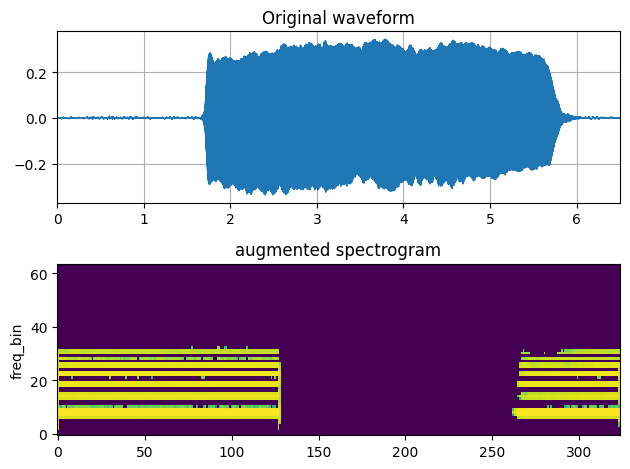

In [10]:
# plot spectrogram
import torch
import torchaudio
from torchaudio import functional
from torchaudio import transforms

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    

fig, axs = plt.subplots(2, 1)
plot_waveform(aud[0], aud[1], title="Original waveform", ax=axs[0])
plot_spectrogram(aug_sg[0], title="augmented spectrogram", ax=axs[1])
fig.tight_layout()

In [11]:
# original audio
SPEECH_WAVEFORM, SAMPLE_RATE = AudioUtil.open(test_file)
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [12]:
# modified audio
Audio(aud_ts[0].numpy(), rate=aud_ts[1])

# Training

In [13]:
from torch.utils.data import random_split

data_path = ''

myds = SoundDS(rm1.processed_df, data_path)
# def __init__(self, df, data_path,channel,transform_type = 'default')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8) # 80% of data in training set
num_val =num_items - num_train
num_unused = num_items - num_train - num_val

train_ds, val_ds = random_split(myds, [num_train,num_val]) 

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [14]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model - custom architecture
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=12)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [15]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
  losses = []
  accuracies = []
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    losses.append(avg_loss)
    accuracies.append(acc)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  return losses, accuracies
  
num_epochs=5   # Just for demo, adjust this higher.
losses, accuracies = training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.02, Accuracy: 0.37
Epoch: 1, Loss: 0.99, Accuracy: 0.70
Epoch: 2, Loss: 0.62, Accuracy: 0.81
Epoch: 3, Loss: 0.49, Accuracy: 0.86
Epoch: 4, Loss: 0.42, Accuracy: 0.88
Finished Training


## Load from checkpoint

# Evaluation

In [16]:
train_data = [accuracies,losses]

# Column names
columns = ['accuracy','loss']

# Create DataFrame
train_df = pd.DataFrame({col: values for col, values in zip(columns, train_data)}).reset_index(names = 'epoch')
train_df.to_csv('./resources/viz/train_df.csv',index=False)

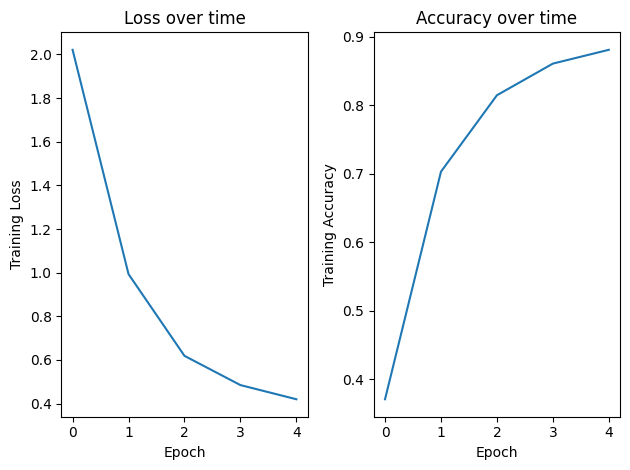

In [17]:
def plot_train_acc(train_df):
    """Create (colored) scatter plot with optional regression line.
    """
    # ax.set_title(f'Pred Filter = {pred_filter}')
    # ax.set_xlabel('Confidence Midpoint')
    # ax.set_ylabel('Accuracy')

    fig, axs = plt.subplots(1, 2)
    ax = axs[0]
    ax.set_title('Loss over time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.plot(train_df['epoch'],train_df['loss'])

    ax = axs[1]
    ax.set_title('Accuracy over time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Accuracy')
    ax.plot(train_df['epoch'],train_df['accuracy'])
    fig.tight_layout()
    return fig

fig = plot_train_acc(train_df)
fig.show()

# Save Model

In [18]:
PATH = './myModel.pth'
torch.save(myModel.state_dict(), PATH)

# Inference

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# cm = confusion_matrix(y_test, predictions)
# ConfusionMatrixDisplay(cm).plot()

# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    predictions = []
    probs = []
    labels_ = []
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      # print(inputs.shape)
      # Get predictions
      outputs = model(inputs)
      pred_probs = torch.nn.functional.softmax(outputs, dim=1)
      max_probs, _ = torch.max(pred_probs,1)
      [probs.append(i) for i in max_probs.tolist()]

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # add prediction to confusion matrix
      [predictions.append(i) for i in prediction.tolist()]
      # predictions.append(prediction)
      # print(prediction.tolist())
      # add label to confusion matrix
      [labels_.append(i) for i in labels.tolist()]
      # print(labels)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  
  # return (labels_,)
  cm = confusion_matrix(labels_, predictions)
  return predictions, labels_, probs, cm
  

# Run inference on trained model with the validation set
predictions, labels, probs, cm = inference(myModel, val_dl)


Accuracy: 0.88, Total items: 1527


In [20]:
# save confusion matrix for plotting
with open('resources/viz/cm.pkl', 'wb') as file:
    pickle.dump(cm, file)

In [21]:
# Data Frame for Calibration:
eval_df = pd.DataFrame({
    'label': labels,
    'pred': predictions,
    'prob': probs
})

eval_df.head(10)
eval_df.to_csv('./resources/viz/calib_df.csv',index=False)
# Buckets of size .05

# Calculate accuracy

# plot pred vs actual overall and by instrument

In [22]:
def calculate_bucket_metrics(df, pred_filter=None):
    """
    Buckets `prob` in steps of 0.05, and calculates the percentage of `label` matching `pred` for each bucket.
    Optionally filters rows where `pred` equals a specific value.

    Args:
        df (pd.DataFrame): A DataFrame with columns `label`, `pred`, and `prob`.
        pred_filter (optional): A value to filter the `pred` column. If None, no filtering is applied.

    Returns:
        pd.DataFrame: A DataFrame with columns `bucket`, `match_percentage`, `count`, and `bucket_midpoint`.
    """
    # Drop rows with NaNs in relevant columns
    df = df.dropna(subset=['label', 'pred', 'prob'])
    
    # Optional filtering based on `pred_filter`
    if pred_filter is not None:
        df = df[df['pred'] == pred_filter]

    # Create buckets for `prob`
    bins = [i * 0.05 for i in range(21)]
    df['bucket'] = pd.cut(df['prob'], bins=bins, right=False)

    # Group by buckets and calculate metrics
    grouped = df.groupby('bucket').agg(
        match_percentage=('label', lambda x: 100 * (x == df.loc[x.index, 'pred']).mean()),
        count=('label', 'size')
    ).reset_index()

    # Add bucket midpoints
    grouped['bucket_midpoint'] = grouped['bucket'].apply(lambda x: x.mid * 100)

    return grouped



result = calculate_bucket_metrics(eval_df, pred_filter=1)
print(result)

         bucket  match_percentage  count bucket_midpoint
0   [0.0, 0.05)               NaN      0             2.5
1   [0.05, 0.1)               NaN      0             7.5
2   [0.1, 0.15)               NaN      0            12.5
3   [0.15, 0.2)               NaN      0            17.5
4   [0.2, 0.25)          0.000000      1            22.5
5   [0.25, 0.3)         25.000000      4            27.5
6   [0.3, 0.35)         50.000000      4            32.5
7   [0.35, 0.4)         71.428571      7            37.5
8   [0.4, 0.45)         25.000000      4            42.5
9   [0.45, 0.5)         40.000000     10            47.5
10  [0.5, 0.55)         62.500000      8            52.5
11  [0.55, 0.6)         66.666667      6            57.5
12  [0.6, 0.65)         81.818182     11            62.5
13  [0.65, 0.7)         87.500000      8            67.5
14  [0.7, 0.75)        100.000000     12            72.5
15  [0.75, 0.8)         90.000000     10            77.5
16  [0.8, 0.85)        100.0000

/tmp/ipykernel_43373/268356104.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bucket').agg(


## Calibration

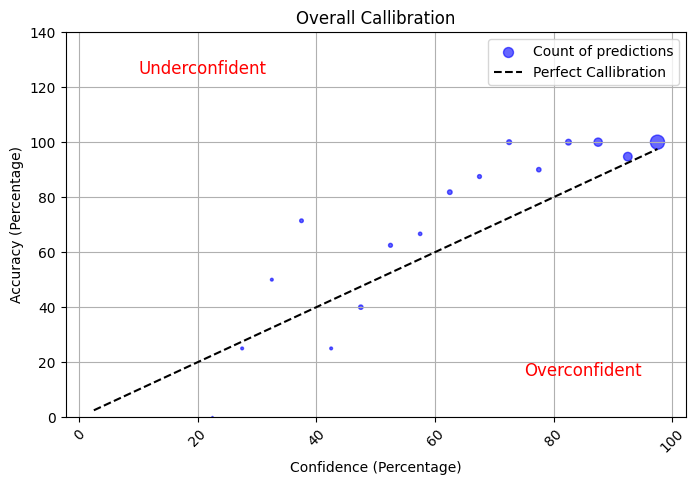

In [23]:
# Line plot
plt.figure(figsize=(8, 5))  # Set figure size
plt.scatter(
    result['bucket_midpoint'],              # X-axis: bucket midpoints
    result['match_percentage'],             # Y-axis: match percentage
    s=result['count'],                      # Bubble size: proportional to count
    alpha=0.6,                              # Transparency for better visualization
    label='Count of predictions', 
    color='blue'                            # Bubble color
)
# Plot the y=x line (using numerical range)
plt.plot(result['bucket_midpoint'], result['bucket_midpoint'], linestyle='--', color='black', label="Perfect Callibration")

# Add labels, title, legend, and grid
plt.xlabel('Confidence (Percentage)')
plt.xticks(rotation=45)
plt.ylabel('Accuracy (Percentage)')
plt.ylim(0, 140)
plt.title('Overall Callibration')
plt.legend()
plt.grid(True)

plt.text(
        x=10,   # Position near the left edge of the chart
        y=130,                                  # Position near the top
        s='Underconfident',                     # Text to display
        fontsize=12,                            # Font size for annotation
        color='red',                            # Text color
        ha='left',                              # Align text to the left
        va='top'                                # Align text to the top
    )

plt.text(
        x=75,   # Position near the left edge of the chart
        y=20,                                  # Position near the top
        s='Overconfident',                     # Text to display
        fontsize=12,                            # Font size for annotation
        color='red',                            # Text color
        ha='left',                              # Align text to the left
        va='top'                                # Align text to the top
    )

# Show the plot
plt.show()

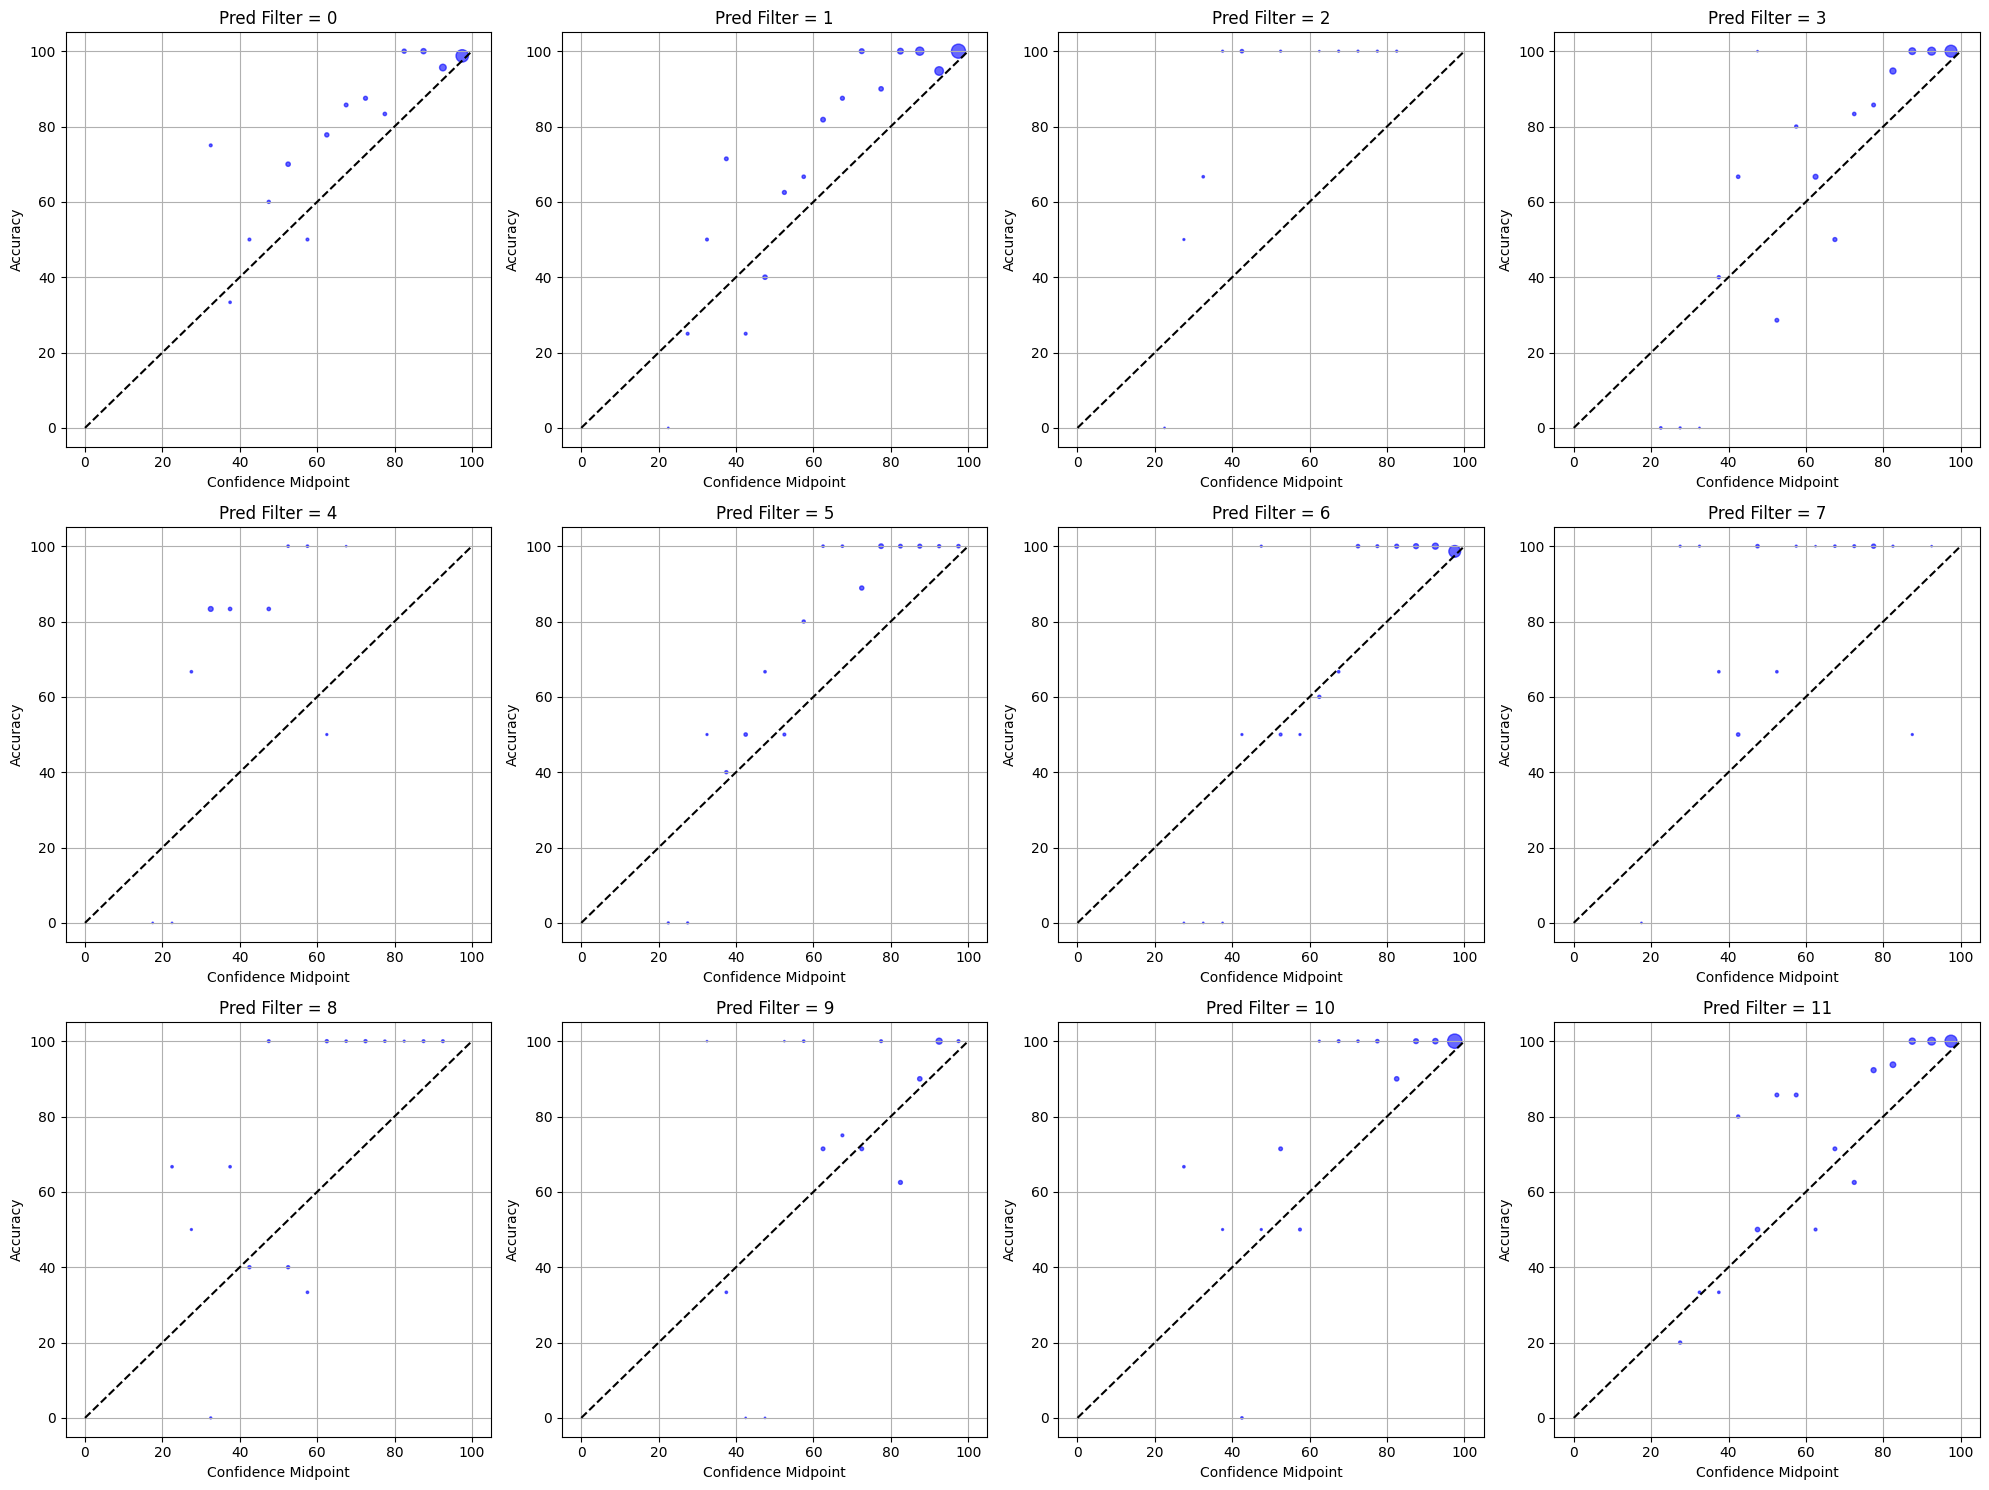

In [24]:
# Define the function to calculate bucket metrics (from earlier)
def calculate_bucket_metrics(df, pred_filter=None):
    df = df.dropna(subset=['label', 'pred', 'prob'])
    if pred_filter is not None:
        df = df[df['pred'] == pred_filter]
    bins = [i * 0.05 for i in range(21)]
    df['bucket'] = pd.cut(df['prob'], bins=bins, right=False)
    grouped = df.groupby('bucket',observed = False).agg(
        match_percentage=('label', lambda x: 100 * (x == df.loc[x.index, 'pred']).mean()),
        count=('label', 'size')
    ).reset_index()
    grouped['bucket_midpoint'] = grouped['bucket'].apply(lambda x: x.mid * 100)
    return grouped

# Create a grid of plots
unique_preds = sorted(eval_df['pred'].unique())  # Get unique pred values (12 in this case)
n_preds = len(unique_preds)

rows = 3  # Adjust grid rows
cols = 4  # Adjust grid columns

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Create a grid of subplots
axes = axes.flatten()  # Flatten axes for easy iteration

# Iterate through each pred filter and corresponding subplot
for i, pred_filter in enumerate(unique_preds):
    ax = axes[i]
    # Filter the data and calculate metrics
    filtered_result = calculate_bucket_metrics(eval_df, pred_filter=pred_filter)
    
    # Bubble plot for the filtered result
    ax.scatter(
        filtered_result['bucket_midpoint'], 
        filtered_result['match_percentage'], 
        s=filtered_result['count'], 
        alpha=0.6, 
        color='blue'
    )
    ax.plot(
        [0, 100], [0, 100], linestyle='--', color='black', label='y = x (Ideal)'
    )
    ax.set_title(f'Pred Filter = {pred_filter}')
    ax.set_xlabel('Confidence Midpoint')
    ax.set_ylabel('Accuracy')
    ax.grid(True)

# Hide empty subplots if the grid is larger than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Confusion Matrix

In [25]:
def display_cm(cm,instrument_map):

    fig = plt.figure(figsize=(8, 5))

    disp = ConfusionMatrixDisplay(cm,display_labels = instrument_map.sort_values('target_instrument')['instrument_name'])
    disp.plot()
    plt.title('Confusion Matrix on Validation Set (n=1500)')
    plt.xticks(rotation = 45)
    return fig

fig = display_cm(cm,instrument_map)
fig.show()
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=clf.classes_)
# disp.plot()
# <...>
# plt.show()

NameError: name 'instrument_map' is not defined

<Figure size 800x500 with 0 Axes>

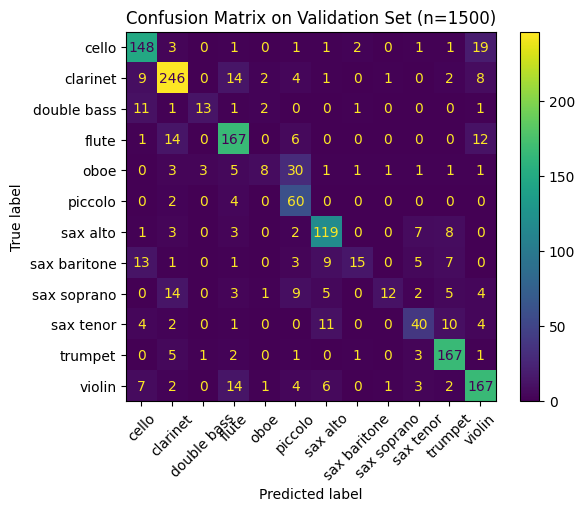

In [339]:
with open('resources/viz/cm.pkl', 'rb') as file:
    cm = pickle.load(file)
fig = display_cm(cm,instrument_map)
fig.show()

In [345]:
import matplotlib.pyplot as plt

def plot_cm(cm,instrument_list):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(instrument_list)), labels=instrument_list)
    ax.set_yticks(np.arange(len(instrument_list)), labels=instrument_list)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(instrument_list)):
        for j in range(len(instrument_list)):
            text = ax.text(j, i, cm[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix on Validation Set (n=1500)")
    fig.tight_layout()
    return fig

In [360]:
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Model Evaluation

In [283]:
target_names = instrument_map.sort_values('target_instrument')['instrument_name'].to_list()

In [284]:
from sklearn import metrics

# # Constants
# C="Cat"
# F="Fish"
# H="Hen"

# # True values
# y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# # Predicted values
# y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H]

# # Print the confusion matrix
# print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(labels, predictions, target_names=target_names,digits=3))


print(metrics.cohen_kappa_score(labels, predictions))

              precision    recall  f1-score   support

       cello      0.763     0.836     0.798       177
    clarinet      0.831     0.857     0.844       287
 double bass      0.765     0.433     0.553        30
       flute      0.773     0.835     0.803       200
        oboe      0.571     0.145     0.232        55
     piccolo      0.500     0.909     0.645        66
    sax alto      0.778     0.832     0.804       143
sax baritone      0.750     0.278     0.405        54
 sax soprano      0.800     0.218     0.343        55
   sax tenor      0.645     0.556     0.597        72
     trumpet      0.823     0.923     0.870       181
      violin      0.770     0.807     0.788       207

    accuracy                          0.761      1527
   macro avg      0.731     0.636     0.640      1527
weighted avg      0.764     0.761     0.743      1527

0.7281366196956387


As you can see, we achieved 87% accuracy on our validation set after only 5 epochs. By percentage, the trickiest instruments to differentiate appear to be the Violin and the Cello or the Oboe and the Clarinet. This type of work offers many avenues for future research!

# Next Steps

In [30]:
# next steps:
# train on more data, more epochs
# evaluation: https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2
# continue calibration: https://medium.com/@anuj_shah/model-calibration-a-step-towards-trustworthy-and-reliable-ai-1181f2fef2c3

# can try additional transforms see: https://cs229.stanford.edu/proj2017/final-reports/5242716.pdf
# add additional metadata to model
# add analysis as features to the model

# play with architecture
# pre trained architecture
# native classifier (done)
# one vs all
# all vs all

# weighted sampler

# explainability: https://medium.com/towards-data-science/building-a-vision-inspection-cnn-for-an-industrial-application-138936d7a34a

# multi-label: evaluate instrumentation

# long term:
# create an app where you upload a file and i tell you what instrument it is


# app development
# reorganize notebook and python code
# need a function that preprocess one image and batch of images

# more viz https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45